In [1]:
import os

import requests
from bs4 import BeautifulSoup
from datetime import datetime

from datetime import datetime
import csv

from operator import itemgetter 
import matplotlib.pyplot as plt

In [2]:
GAMES = "https://www.basketball-reference.com/teams/NYK/2020_games.html"
GAME_ENDPOINT = "https://www.basketball-reference.com/boxscores"
PBP_ENDPOINT = "https://www.basketball-reference.com/boxscores/pbp"

In [3]:
# Lineup Helpers

lineups = {}

scores = set()

roster = {
        '/players/m/morrima03.html': "Marcus Morris",
        '/players/b/barrerj01.html': "RJ Barrett",
        '/players/r/randlju01.html': "Julius Randle",
        '/players/p/portibo01.html': "Bobby Portis",
        '/players/t/trieral01.html': "Allonzo Trier",
        '/players/p/paytoel01.html': "Elfrid Payton",
        '/players/k/knoxke01.html': "Kevin Knox",
        '/players/g/gibsota01.html': "Taj Gibson",
        '/players/e/ellinwa01.html': "Wayne Ellington",
        '/players/s/smithde03.html': "Dennis Smith",
        '/players/n/ntilila01.html': "Frank Ntilikina",
        '/players/d/dotsoda01.html': "Damyean Dotson",
        '/players/b/brazdig01.html': "Ignas Brazdeikis",
        '/players/a/allenka01.html': "Kadeem Allen",
        '/players/w/wooteke01.html': "Kenny Wooten",
        '/players/d/dotsoda01.html': "Damyean Dotson",
        '/players/r/robinmi01.html': "Mitchell Robinson",
        '/players/b/bullore01.html': "Reggie Bullock"
    }

# Convert URL to Player name to recognize player

def knick_switcher(url):
    return{
        '/players/m/morrima03.html': 'Marcus Morris',
        '/players/b/barrerj01.html': "RJ Barrett",
        '/players/r/randlju01.html': "Julius Randle",
        '/players/p/portibo01.html': "Bobby Portis",
        '/players/t/trieral01.html': "Allonzo Trier",
        '/players/p/paytoel01.html': "Elfrid Payton",
        '/players/k/knoxke01.html': "Kevin Knox",
        '/players/g/gibsota01.html': "Taj Gibson",
        '/players/e/ellinwa01.html': "Wayne Ellington",
        '/players/s/smithde03.html': "Dennis Smith",
        '/players/n/ntilila01.html': "Frank Ntilikina",
        '/players/d/dotsoda01.html': "Damyean Dotson",
        '/players/b/brazdig01.html': "Ignas Brazdeikis",
        '/players/h/harklma01.html': "Maurice Harkless",
        '/players/a/allenka01.html': "Kadeem Allen",
        '/players/w/wooteke01.html': "Kenny Wooten",
        '/players/d/dotsoda01.html': "Damyean Dotson",
        '/players/r/robinmi01.html': "Mitchell Robinson",
        '/players/b/bullore01.html': "Reggie Bullock"
    }[url]

In [4]:
# Parse through Play by Play for events

def parse_pbp(pbp_url, starters, starters2, gamedate):
    checkpoint = "12:00"
    current_time = "12:00"
    newQuarter = False
    time = 0
    active = starters # immutable frozenset to be used as a dictionary key
    active2 = starters2 # mutable set to be converted into a frozenset
    orphanlineups = [] # workaround for lack of information on lineup at start of new quarters
    qstats = [] # cached list of stats for any incomplete lineup
    PF = 0
    PA = 0
    qPF = 0 # cached PF for incomplete lineups at start of quarter
    qPA = 0 # cached PA for incomplete lineups at start of quarter
    qtime = 0 # cached time for lineup at start of quarter
    date = gamedate
    Knicks = 0
    Opponent = 0
        
    # locating events
    url = PBP_ENDPOINT+pbp_url
    markup = requests.get(url)
    soup = BeautifulSoup(markup.text, "html.parser")
    event_wrapper = soup.find("div", class_="table_wrapper")
    events = event_wrapper.find_all("td")
    for event in events:
        soup = event
        event = str(event)
        if len(event) < 18 and len(event)>10:
            event = event.replace("<td>","")
            event = event.replace(".0</td>", "")
            current_time = event
        elif len(event)>25: # anything other than a blank event
            if newQuarter: #find as many Knicks as possible before next sub event
                if event.find("enters the game")==-1:
                    for link in soup.find_all('a'):
                        if link.get('href') in roster:
                            if knick_switcher(link.get('href')) not in active2:
                                active2.add(knick_switcher(link.get('href')))
                                for l in orphanlineups:
                                    [l.add(knick_switcher(link.get('href'))) for l in orphanlineups]
                                if len(active2) == 5: # flush out
                                    active = frozenset(active2)
                                    newQuarter = False
                                    for orphan in orphanlineups:
                                        orphan = frozenset(orphan)
                                        for i in range(len(qstats)):
                                            if orphan not in lineups:
                                                lineups[orphan] = [0,0,0,0]
                                            for j in range(len(lineups[orphan])):
                                                lineups[orphan][j] += qstats[i][j]
                                    orphanlineups, qstats = [], []
            if event.find("makes 2-pt")!= -1:
                start = event.find('/players')
                end = event[start:].find('"')+start
                player = event[start:end]
                if player in roster:
                    PF += 2
                    Knicks += 2
                else:
                    PA += 2 
                    Opponent += 2
            elif event.find("makes 3-pt")!= -1:
                start = event.find('/players')
                end = event[start:].find('"')+start
                player = event[start:end]
                if player in roster:
                    PF += 3
                    Knicks += 3
                else:
                    PA += 3
                    Opponent += 3
            elif event.find("makes free")!= -1 or event.find("makes technical")!= -1 or event.find("makes clear")!= -1 or event.find("makes flagrant")!= -1:
                start = event.find('/players')
                end = event[start:].find('"')+start
                player = event[start:end]
                if player in roster:
                    PF += 1
                    Knicks += 1
                else:
                    PA += 1
                    Opponent += 1
            elif event.find("enters the game")!=-1: # Substitution
                
                # find player subbed in
                start = event.find('/players')
                end = event[start:].find('"')+start
                player = event[start:end]
                
                # add lineup's stats
                if player in roster:
                    s1 = current_time
                    s2 = checkpoint
                    format = '%M:%S'
                    time = (datetime.strptime(s2, format) - datetime.strptime(s1, format)).total_seconds()
                    checkpoint = current_time
                    stats = [PF, PA, time, 0]
                    
                    # find player subbed out and add to lineup if current is incomplete
                    start2 = event[end:].find('/players')+end
                    end2 = event[start2:].find('"')+start2
                    player2 = event[start2:end2]
                                        
                    # Substitution for incomplete lineup
                    
                    if newQuarter:
                        if knick_switcher(player2) not in active2:
                            active2.add(knick_switcher(player2)) # add to current lineup
                            for l in orphanlineups: # add to any orphan lineups
                                [l.add(knick_switcher(player2)) for l in orphanlineups]
                            if len(active2) == 5: # found mystery person in the nick of time, flush out set
                                newQuarter = False
                                for orphan in orphanlineups:
                                    orphan = frozenset(orphan)
                                    for i in range(len(qstats)):
                                        if orphan not in lineups:
                                            lineups[orphan] = [0,0,0,0]
                                        for j in range(len(lineups[orphan])):
                                            lineups[orphan][j] += qstats[i][j]
                                orphanlineups, qstats = [], []
                                active2.remove(knick_switcher(player2))
                                active2.add(knick_switcher(player))
                                PF = 0
                                PA = 0
                                active = frozenset(active2)
                            else:
                                for i in range(len(stats)):
                                    qstats[len(qstats)-1][i] += stats[i]
                                active2.remove(knick_switcher(player2))
                                active2.add(knick_switcher(player))
                                orphanlineups.append(active2)
                                qstats.append([0,0,0,0])
                                PF = 0
                                PA = 0
                        else: #add stats to incomplete lineup, then add new lineup with fresh stats
                            for i in range(len(stats)):
                                qstats[len(qstats)-1][i] += stats[i]
                            active2.remove(knick_switcher(player2))
                            active2.add(knick_switcher(player))
                            orphanlineups.append(active2)
                            qstats.append([0,0,0,0])
                            PF = 0
                            PA = 0

                    # Normal substitution
                    else:
                        if active not in lineups:
                            lineups[active] = [0,0,0,0]
                        lineups[active] = [lineups[active][i] + stats[i] for i in range(len(stats))]
                        
                        # reflect changes in lineup
                        active2.remove(knick_switcher(player2))
                        active2.add(knick_switcher(player))
                        active = frozenset(active2)
                        PF = 0
                        PA = 0 
            elif event.find("End of")!=-1:
                s1 = current_time
                s2 = checkpoint
                format = '%M:%S'
                time = (datetime.strptime(s2, format) - datetime.strptime(s1, format)).total_seconds()
                current_time='12:00'
                checkpoint='12:00'
                if event.find("overtime")!=-1:
                    current_time='5:00'
                    checkpoint='5:00'
                newQuarter = True
                active2 = set()
                if len(orphanlineups) == 0:
                    orphanlineups = [set()]
                    qstats = [[0,0,0,0]]
                else:
                   print(orphanlineups, "NOT SAVED. THIS NEVER HAPPENS BUT IF IT DOES, THAT'S BAD!")
            else:
                pass # irrelevant - either empty or useless event
        else:
            pass # irrelevant - always empty
    if date == "03/23/2020": # Adding back into the roster for later - Knicks do not play Clippers again
        roster['/players/m/morrima03.html'] = "Marcus Morris"
    scores.add((Knicks,Opponent))
    if Knicks>Opponent:
        print("Final Score: " + str(Knicks) + "-" + str(Opponent) + " (Knicks Win!)")
    else:
        print(("Final Score: " + str(Knicks) + "-" + str(Opponent) + " (Knicks Lose)"))
    
# Parse through Box Score for Starting Lineup
def find_starters(box_url):
    url = GAME_ENDPOINT+box_url
    markup = requests.get(url)
    soup = BeautifulSoup(markup.text, "html.parser")

    # Finding Knicks Roster
    count = 0
    lineup = set()
    sliceIndex = str(soup).find('all_box-NYK-game-basic')
    soup = str(soup)[sliceIndex:]
    sliceIndex = soup.find('<tbody')
    soup = soup[sliceIndex:] # knicks roster

    # Grab the starting five players for the Knicks to set as starting lineup
    while count < 5 and soup != "":
        start = soup.find('"/players') + 1
        end = soup[start:].find('"') + start
        knick = soup[start:end] # first player
        if knick in roster:
            lineup.add(knick_switcher(knick))
            count += 1
            soup = soup[end:]
        else:
            print(knick + " is not a Knick")
    lineup = ([x for x in lineup])
    active = {x for x in lineup}
    lineup=frozenset(lineup)
    if lineup not in lineups:
        lineups[lineup] = [0,0,0,0]
    return lineup, active

# Parse through Games
def parse_games():
    count = 0
    print("Loading Games:")
    markup = requests.get(GAMES)
    soup = BeautifulSoup(markup.text, "html.parser")
    games = soup.find('tbody')
    for row in games:
        if row.find('tr') != -1:
            if str(row).find('Box Score') != -1:
                start = str(row).find("/boxscores/2")
                row = str(row)[start+1:]
                start = str(row).find("/")
                end = str(row)[start:].find('"')+start
                url = str(row)[start:end]
                date = url[5:7] + "/"+url[7:9]+"/"+url[1:5]
                if date == "02/06/2020": # Knicks trade for Maurice Harkless
                    roster['/players/h/harklma01.html'] = "Maurice Harkless"
                if date == "03/23/2020": # Knicks play Clippers after trading Marcus Morris
                    del roster['/players/m/morrima03.html']
                if len(url) > 0:
                    print("Grabbing info from game on " + url[5:7] + "/"+url[7:9]+"/"+url[1:5])
                    starters, starters2 = find_starters(url)
                    parse_pbp(url, starters, starters2,date)
                    count += 1
    print(str(count)+" games tracked.")

In [5]:
# Run Data Collection

parse_games()

Loading Games:
Grabbing info from game on 10/23/2019
Final Score: 111-120 (Knicks Lose)
Grabbing info from game on 10/25/2019
Final Score: 109-113 (Knicks Lose)
Grabbing info from game on 10/26/2019
Final Score: 95-118 (Knicks Lose)
Grabbing info from game on 10/28/2019
Final Score: 105-98 (Knicks Win!)
Grabbing info from game on 10/30/2019
Final Score: 83-95 (Knicks Lose)
Grabbing info from game on 11/01/2019
Final Score: 102-104 (Knicks Lose)
Grabbing info from game on 11/03/2019
Final Score: 92-113 (Knicks Lose)
Grabbing info from game on 11/06/2019
Final Score: 102-122 (Knicks Lose)
Grabbing info from game on 11/08/2019
Final Score: 106-102 (Knicks Win!)
Grabbing info from game on 11/10/2019
Final Score: 87-108 (Knicks Lose)
Grabbing info from game on 11/12/2019
Final Score: 102-120 (Knicks Lose)
Grabbing info from game on 11/14/2019
Final Score: 106-103 (Knicks Win!)
Grabbing info from game on 11/16/2019
Final Score: 102-103 (Knicks Lose)
Grabbing info from game on 11/18/2019
Fina

TOP 5 LINEUPS BY MINUTES PLAYED:
Lineup, Minutes, +/- per minute
frozenset({'Taj Gibson', 'RJ Barrett', 'Frank Ntilikina', 'Julius Randle', 'Marcus Morris'}) 235 -54 -0.23
frozenset({'Julius Randle', 'Reggie Bullock', 'Taj Gibson', 'Marcus Morris', 'Elfrid Payton'}) 111 2 0.02
frozenset({'Mitchell Robinson', 'RJ Barrett', 'Julius Randle', 'Marcus Morris', 'Elfrid Payton'}) 99 2 0.02
frozenset({'Taj Gibson', 'RJ Barrett', 'Julius Randle', 'Marcus Morris', 'Elfrid Payton'}) 75 -26 -0.35
frozenset({'Mitchell Robinson', 'RJ Barrett', 'Frank Ntilikina', 'Julius Randle', 'Marcus Morris'}) 71 -30 -0.42
TOP 5 LINEUPS BY TOTAL PLUS-MINUS:
Lineup, Minutes, +/- per minute
frozenset({'Damyean Dotson', 'Kevin Knox', 'Frank Ntilikina', 'Julius Randle', 'Bobby Portis'}) 23 0.91
frozenset({'RJ Barrett', 'Julius Randle', 'Marcus Morris', 'Bobby Portis', 'Elfrid Payton'}) 39 0.51
frozenset({'Mitchell Robinson', 'Kevin Knox', 'Damyean Dotson', 'Julius Randle', 'Elfrid Payton'}) 10 1.5
frozenset({'Mitchel

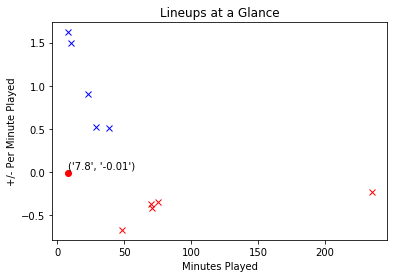

In [6]:
# Evaluating lineups

plus_minus = {}
time = {}
top5_pm_mins = {}
bottom5_pm_mins = {}
top5_mins_pm = {}
average_pm_per_min = 0
count = 0

# calculate plus-minus
for lineup in lineups:
    lineups[lineup][3] = lineups[lineup][0]-lineups[lineup][1]
    plus_minus[lineup] = lineups[lineup][3]
    try:
        average_pm_per_min += lineups[lineup][3]/lineups[lineup][2]
    except: # no minutes played
        pass
    time[lineup] = lineups[lineup][2]
    count += 1

average_mins = round((48*62+20)/(len(lineups)-130), 2) #130 lineups with no time played
average_pm_per_min = round(average_pm_per_min/count, 2)
top5_pm = dict(sorted(plus_minus.items(), key = itemgetter(1), reverse = True)[:5]) 
bottom5_pm = dict(sorted(plus_minus.items(), key = itemgetter(1))[:5])
top5_mins = dict(sorted(time.items(), key = itemgetter(1), reverse = True)[:5])

print("TOP 5 LINEUPS BY MINUTES PLAYED:")
print("Lineup, Minutes, +/- per minute")
for key in top5_mins:
    top5_mins[key] = round(top5_mins[key]/60)
    top5_mins_pm[key] = lineups[key][3]
    print(key, top5_mins[key], lineups[key][3], round(lineups[key][3]/top5_mins[key],2))
    
print("TOP 5 LINEUPS BY TOTAL PLUS-MINUS:")
print("Lineup, Minutes, +/- per minute")
for key in top5_pm:
    top5_pm_mins[key] = round(lineups[key][2]/60)
    top5_pm[key] = round(top5_pm[key]/top5_pm_mins[key], 2)
    print(key, top5_pm_mins[key], top5_pm[key])
    
print("BOTTOM 5 LINEUPS BY TOTAL PLUS-MINUS:")
print("Lineup, Minutes, +/- per minute")
for key in bottom5_pm: 
    bottom5_pm_mins[key] = round(lineups[key][2]/60)
    bottom5_pm[key] = round(bottom5_pm[key]/bottom5_pm_mins[key], 2)
    print(key, bottom5_pm_mins[key], bottom5_pm[key])

t5pm = [y[1] for y in top5_pm.items()]
t5pm_mins = [y[1] for y in top5_pm_mins.items()]

b5pm = [y[1] for y in bottom5_pm.items()]
b5pm_mins = [y[1] for y in bottom5_pm_mins.items()]

plt.title("Lineups at a Glance")
plt.plot(t5pm_mins, t5pm, 'bx')
plt.plot(b5pm_mins, b5pm, 'rx')
plt.plot(average_mins, average_pm_per_min, 'ro')
plt.text(average_mins+.05, average_pm_per_min+.05, (str(average_mins), str(average_pm_per_min)))
plt.xlabel("Minutes Played")
plt.ylabel("+/- Per Minute Played")
plt.show()

FUTURE WORK:

• Run lineup analyses for all NBA teams, allowing for rankings of lineup performance across the league

• Evaluate lineup performance vs strength of competition

• Calculate Adjusted/True Plus-Minus for individual players